In [2]:
import os
import sklearn
import numpy as np
import pandas as pd
import joblib as jl
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('DummiesV2.csv')

On standardise puis sépare les données :

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
targets = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']
X = data.drop(targets, axis=1)
X = pd.DataFrame(data=StandardScaler().fit_transform(X), columns=X.columns)
Y = data[targets].values.argmax(axis=1) # cela réordonne bien les modalités puisque `targets` est ordonnée.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0)

In [5]:
def plot_confusion_matrix(matrix, classes,
                          normalize=False,
                          cmap=plt.cm.Blues,
                          title=None):

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        title = title if title else "Matrice de confusion (normalisée)"
    else:
        title = title if title else "Matrice de confusion (non normalisée)"

    sns.set_style('ticks')
    res = sns.heatmap(matrix,
                      cmap=cmap,
                      cbar=True,
                      square=True,
                      annot=True)

    for _, spine in res.spines.items():
        spine.set_visible(True)

    plt.title(title)
    tick_marks = np.arange(len(classes)) + .5
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    plt.tight_layout()
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()

# Avec une régression logistique

### Non-équilibrée

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

retrain = False
if not os.path.isfile('regression-log-unbalanced.joblib') or retrain:
    ULR = LogisticRegression(multi_class='multinomial', max_iter=1000)
    selector_ULR = RFECV(ULR, cv=StratifiedKFold(2), scoring="accuracy", step=1, verbose=4).fit(X_train, Y_train)
    jl.dump(selector_ULR, 'regression-log-unbalanced.joblib')
else:
    selector_ULR = jl.load('regression-log-unbalanced.joblib')

ULR = selector_ULR.estimator_

In [7]:
selected_ULR = [variable for variable, boolean in zip(X.columns.tolist(), selector_ULR.support_.tolist()) if boolean]
print('Accuracy :', np.mean(ULR.predict(X_test[selected_ULR]) == Y_test))

Accuracy : 0.6493888637392485


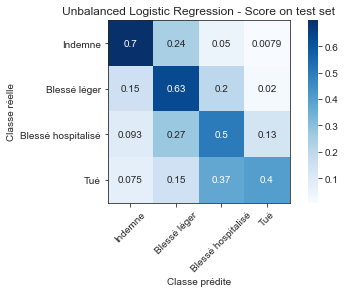

In [8]:
from sklearn import metrics
conf = metrics.confusion_matrix(ULR.predict(X_test[selected_ULR]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Logistic Regression - Score on test set');

### Equilibrée

In [9]:
retrain = True
if not os.path.isfile('regression-log-balanced.joblib') or retrain:
    BLR = LogisticRegression(multi_class='multinomial', max_iter=1000, class_weight='balanced')
    selector_BLR = RFECV(BLR, cv=StratifiedKFold(2), scoring="accuracy", step=1, verbose=4).fit(X_train, Y_train)
    jl.dump(selector_BLR, 'regression-log-balanced.joblib')
else:
    selector_BLR = jl.load('regression-log-balanced.joblib')

BLR = selector_BLR.estimator_

Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
F

In [24]:
selected_BLR = [variable for variable, boolean in zip(X.columns.tolist(), selector_BLR.support_.tolist()) if boolean]
print('Accuracy :', np.mean(BLR.predict(X_test[selected_BLR]) == Y_test))

Accuracy : 0.5851063829787234


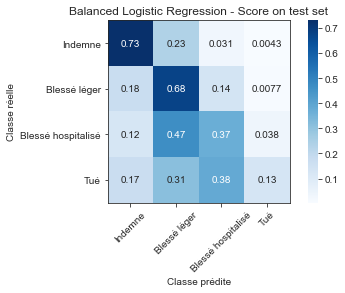

In [25]:
conf = metrics.confusion_matrix(BLR.predict(X_test[selected_BLR]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Logistic Regression - Score on test set');

# Avec un Random Forest

### Non-équilibré

In [12]:
from sklearn.ensemble import RandomForestClassifier

retrain = False
if not os.path.isfile('randomforest-unbalanced.joblib') or retrain:
    URF = RandomForestClassifier()
    selector_URF = RFECV(URF, cv=StratifiedKFold(2), scoring="accuracy", step=1, verbose=4).fit(X_train, Y_train)
    jl.dump(selector_URF, 'randomforest-unbalanced.joblib')
else:
    selector_URF = jl.load('randomforest-unbalanced.joblib')

URF = selector_URF.estimator_

In [13]:
selected_URF = [variable for variable, boolean in zip(X.columns.tolist(), selector_URF.support_.tolist()) if boolean]
print('Accuracy :', np.mean(URF.predict(X_test[selected_URF]) == Y_test))

Accuracy : 0.6550726824606408


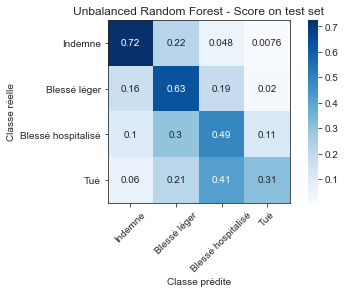

In [14]:
conf = metrics.confusion_matrix(URF.predict(X_test[selected_URF]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Random Forest - Score on test set');

### Equilibré

In [15]:
retrain = False
if not os.path.isfile('randomforest-balanced.joblib') or retrain:
    BRF = RandomForestClassifier(class_weight='balanced')
    selector_BRF = RFECV(BRF, cv=StratifiedKFold(2), scoring="accuracy", step=1, verbose=4).fit(X_train, Y_train)
    jl.dump(selector_BRF, 'randomforest-balanced.joblib')
else:
    selector_BRF = jl.load('randomforest-balanced.joblib')

BRF = selector_BRF.estimator_

In [16]:
selected_BRF = [variable for variable, boolean in zip(X.columns.tolist(), selector_BRF.support_.tolist()) if boolean]
print('Accuracy :', np.mean(BRF.predict(X_test[selected_BRF]) == Y_test))

Accuracy : 0.6555756752678437


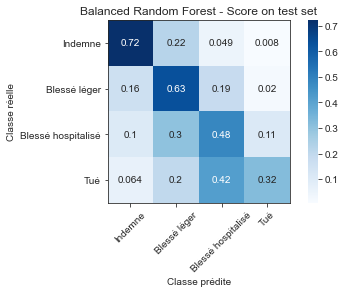

In [17]:
conf = metrics.confusion_matrix(BRF.predict(X_test[selected_BRF]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Random Forest - Score on test set');

### Optimisation des hyperparamètres

In [18]:
X_train_RF = X_train[selected_BRF]
X_test_RF = X_test[selected_BRF]

In [19]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

retrain = False
if not os.path.isfile('randomforest-optimized.joblib') or retrain:
    rfc = RandomForestClassifier(class_weight='balanced')
    parameters = {'max_depth': np.logspace(0,2,10).astype(int),
                  'criterion': ['gini', 'entropy'],
                  'min_samples_leaf': [1],
                  'max_features': ['sqrt, log2'],
                  'n_estimators': [100]}
    cv_res = GridSearchCV(rfc, parameters, cv=StratifiedKFold(5), scoring='accuracy', verbose=4).fit(X_train_RF, Y_train)
    jl.dump(cv_res, 'randomforest-optimized.joblib')
else:
    cv_res = jl.load('randomforest-optimized.joblib')
    
ORF = cv_res.best_estimator_
scores = pd.DataFrame(cv_res.cv_results_)
ORF.get_params()



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 35,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

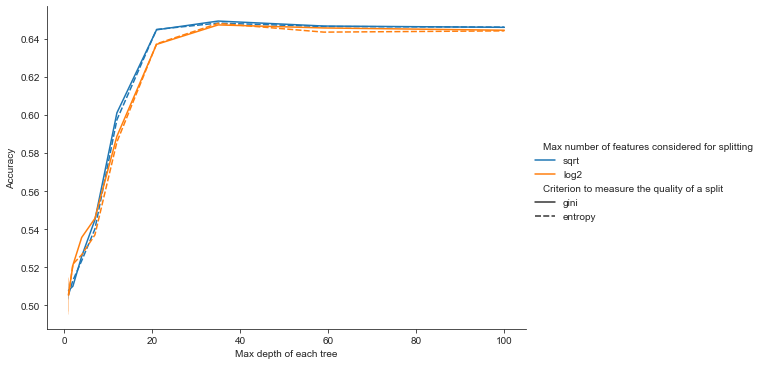

In [20]:
scores.rename(columns={'mean_test_score': 'Accuracy',
                       'param_max_depth': 'Max depth of each tree',
                       'param_criterion': 'Criterion to measure the quality of a split',
                       'param_max_features': 'Max number of features considered for splitting'},
              inplace=True)
sns.relplot(data=scores, kind='line', x='Max depth of each tree', y='Accuracy',
            style='Criterion to measure the quality of a split', hue='Max number of features considered for splitting', aspect=1.5);

Accuracy on test set : 0.6605050047784317


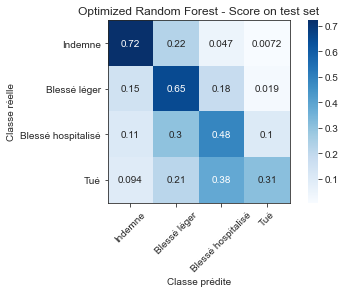

In [21]:
print('Accuracy on test set :', np.mean(ORF.predict(X_test_RF) == Y_test))
conf = metrics.confusion_matrix(ORF.predict(X_test_RF), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Optimized Random Forest - Score on test set');